# Hand-in 3, Part 1: Data handling and exploration

In this first notebook you will show us how you handle data being separated over several files, as well as exploring the quality and properties of your data.

#### Section 1: bash scripting

You have downloaded a zip file containing 5 CSV files, each containing part of the data you need. First, use your bash tools to look at the headers and size of the file. What do the different files contain?

Write a bash script that concatenates the 4 data files (except the flow_criticality_data.csv file). Exlain in the markdown cell below, what each part of your script does.

**Q#1** *Explain your script here (by double clicking on this text).*

1: #!/bin/bash

2: cut -d ',' -f1 --complement energy_demand_data.csv | paste -d ',' - exchange_data.csv > helper.csv

3: cut -d ',' -f1 --complement generator_production_data.csv | paste -d ',' - helper.csv > all.csv

4: cut -d ',' -f1 --complement exchange_data.csv | paste -d ',' - all.csv > helper.csv

5: cut -d ',' -f1 --complement renewable_production_data.csv | paste -d ',' - helper.csv > all.csv

6: rm -rf helper.csv


line 1: makes sure the script runs in bash

line 2: cuts the time column out of energy_demand_data.csv and pipes the output to paste. Paste writes linewise from the piped input and exchange_data into helper.csv .   Notice that exchange_data.csv still has the time coloumn.

line 3-5: does the same as line 2, but with the rest of the files, changing to update/read either helper.csv or all.csv

line 6: removes helper.csv


## Section 2: Visualizing the data
Here you will plot the resulting data file from the previous section, and plot it in order to identify missing data and see if you can already draw some conclusions on the data.

* *Hint: remember the hint given in Exc.13.3, on how to find out if your data contains NaN values*

In [1]:
# You will probably be needing the following libraries:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
import numpy as np

In [2]:
# Import your data here
data = {}
data['Raw'] = pd.read_csv('all.csv')
print("NaN's:",data['Raw'].isnull().sum(0).sum())
data['Raw'].isnull().sum(0)

NaN's: 451


renew_node_132        0
renew_node_140        0
renew_node_143        0
renew_node_17         0
renew_node_148        0
renew_node_150        0
renew_node_24         0
renew_node_153        0
renew_node_154        0
renew_node_155        0
renew_node_25         0
renew_node_159        0
renew_node_168        0
renew_node_41         0
renew_node_171        0
renew_node_175        0
renew_node_185        0
renew_node_190        0
renew_node_202        0
renew_node_212        0
renew_node_86         0
renew_node_88         0
renew_node_93         0
renew_node_95         0
renew_node_97         0
renew_node_99         0
renew_node_111        0
renew_node_121        0
renew_node_123        0
export_node_162       0
                     ..
prod_gen_43           9
prod_gen_44           8
prod_gen_45           7
prod_gen_46           7
prod_gen_47          13
prod_gen_48           8
prod_gen_49           7
prod_gen_50           7
prod_gen_51          15
time                  0
export_node_162.

<IPython.core.display.Javascript object>


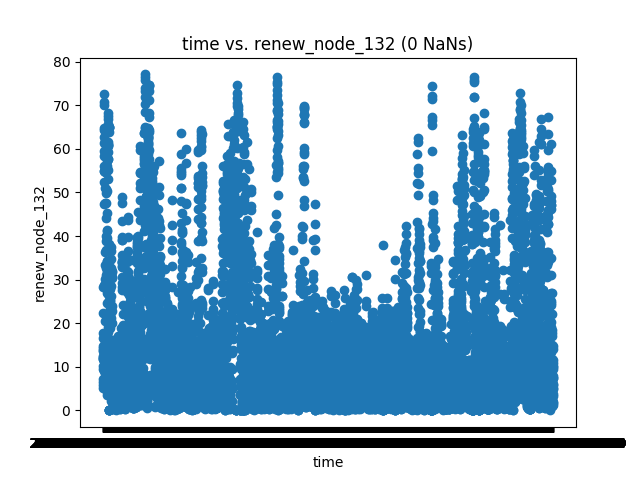

<IPython.core.display.Javascript object>


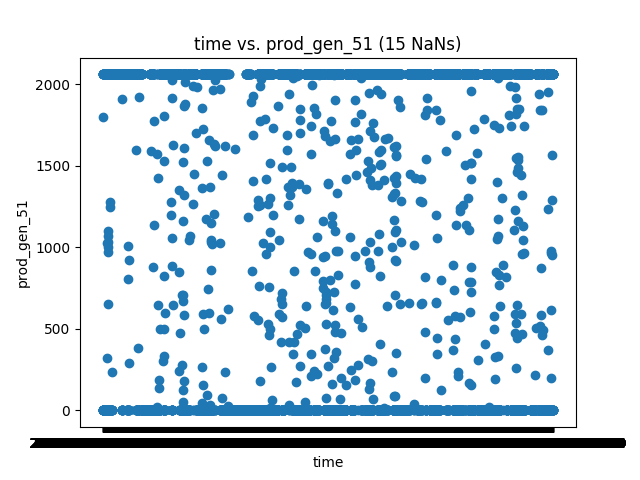

<IPython.core.display.Javascript object>


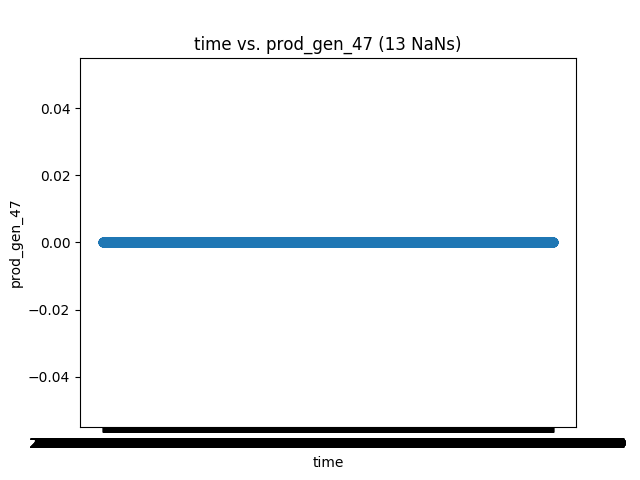

In [3]:
# First do some time series plots on the data, would it be practical to plot all possible scatter plots (scatter matrix)?

# If you have a cluster:
# Sure!  you can see all the data with only 1 command


# If you only have a laptop:
# NO!   There's way too many colomns for a scatter matrix! it would take forever to make the plots.

plt.figure(1)
plt.plot(data['Raw']['time'],data['Raw']['renew_node_132'],'o')
plt.xlabel("time")
plt.ylabel("renew_node_132")
plt.title("time vs. renew_node_132 (0 NaNs)")
plt.show()

plt.figure(2)
plt.plot(data['Raw']['time'],data['Raw']['prod_gen_51'],'o')
plt.xlabel("time")
plt.ylabel("prod_gen_51")
plt.title("time vs. prod_gen_51 (15 NaNs)")
plt.show()

plt.figure(3)
plt.plot(data['Raw']['time'],data['Raw']['prod_gen_47'],'o')
plt.xlabel("time")
plt.ylabel("prod_gen_47")
plt.title("time vs. prod_gen_47 (13 NaNs)")
plt.show()



**Q#2** For this data, what is the reasonable approach to dealing with the NaN values? Why?

Since there is no direct pattern, interpolation is NOT an option.
Dropping rows containing a NaN seems resonable since the columns are to be compared.

In [4]:
# Get rid of your NaNs her
data['noNaN'] = data['Raw'].dropna(axis=0,how='any')



### Feature reduction
Since you must reduce the amount of sensors, you need to find out which ones you can get rid of. 

**Q#3** Why would PCA be useful for this?

PCA is letting you inspect the data in a 2D graph, which is very useful considering the size of this dataset.

When using PCA its possible to narrow down the number of parameters based upon the principal components. You will lose some data, but if you eg. can reduce the ammount of sensors from 137 to 30 while only losing 5% accuracy, it's propably worth it. 

<IPython.core.display.Javascript object>


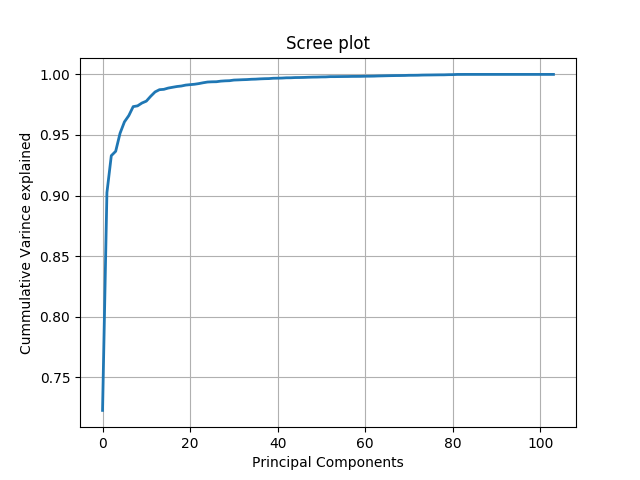

In [8]:
from sklearn.decomposition import PCA
data['noTime'] = data['noNaN'].drop('time',1) # remove timestamps

data['norm'] = (data['noTime'] - data['noTime'].mean()) / (data['noTime'].std())
data['normNoNan'] = data['norm'].dropna(axis=1,how='all') #This removes columns where all numbers are NaN
#df_norm = (noTime - noTime.mean()) / (noTime.std())

pca = PCA(n_components=data['normNoNan'].shape[1])
data['pca'] = pca.fit_transform(data['normNoNan'])

plt.figure(5)
plt.plot(1-pca.explained_variance_ratio_ , linewidth=2)
plt.title("Scree plot")
plt.ylabel("Cummulative Varince explained")
plt.xlabel("Principal Components")
plt.grid()
plt.show()



### Scree plot
**Q#4** How many principal components do you need to explain 90 % of the variance?

As seen on the figure above, only 2 principal component describes 90 % of the variance. Therefore I keep 2.
(if you cant see it, then use the "Pan" tool under the plot)

### Clustering
You want to reduce the amount of field sensors to 20. You should now have from the previous question, an array with all your loading vectors (pca.components\_), one vector per principal component, with 137 elements (one per each sensor). Use clustering to group sensors that behave the same. 

**Q#5** How would you choose which sensors in each cluster you should keep?

I choose 20 clusters, and then choose 1 sensor from each cluster. The sensor chosen from each cluster is the one closest to the clusters midpoint. This is done because the clusters contain sensors which are "alike". Choosing the one closest to te middle is done in hope of the best representation of the cluster. This is done to show the diversity of the dataset.   

This method is not a good choice if there's extreme outliers, as they will be given a cluster of their own. It doesnt seem like this is the case. 

<IPython.core.display.Javascript object>


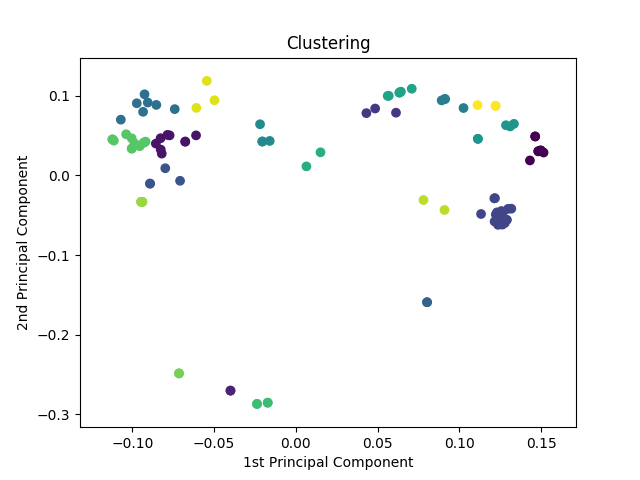

<IPython.core.display.Javascript object>


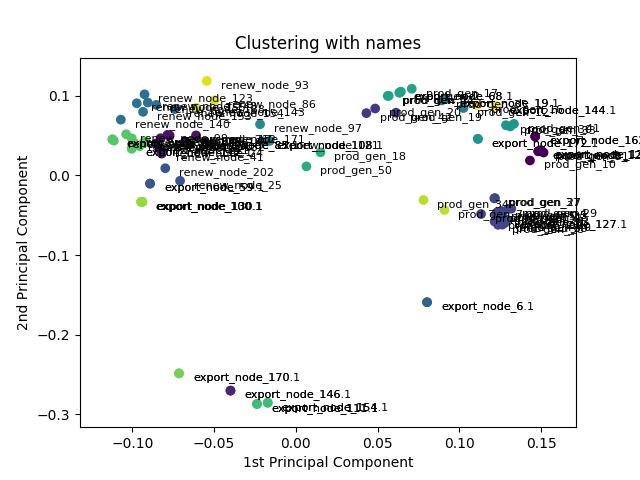

In [7]:
from sklearn.cluster import KMeans
# Apply your clustering here
pcaproj = pca.components_[[0,1]]

kmeans = KMeans(n_clusters=20, random_state=0).fit(pcaproj.T)
cluster_pred=kmeans.predict(pcaproj.T)

plt.figure(6)
plt.scatter(pcaproj[0],pcaproj[1], c=cluster_pred)
plt.title("Clustering")
plt.xlabel("1st Principal Component")
plt.ylabel("2nd Principal Component")
plt.show()



fig,ax = plt.subplots()
plt.scatter(pcaproj[0],pcaproj[1], c=cluster_pred)
for i, txt in enumerate(data["normNoNan"].columns):
    ax.annotate(txt, (pca.components_[0][i],pca.components_[1][i]),xytext=(10,-5), textcoords='offset points', fontsize=8)
plt.title("Clustering with names")
plt.xlabel("1st Principal Component")
plt.ylabel("2nd Principal Component")
plt.show()


In [9]:
clust = pd.DataFrame(data["normNoNan"].columns, columns=["Sensors"])
clust["X"] = pcaproj[0]
clust["Y"] = pcaproj[1]
clust["cluster number"] = cluster_pred

clust["centerX"]=kmeans.cluster_centers_[clust["cluster number"].values,0] # X center of cluster
clust["centerY"]=kmeans.cluster_centers_[clust["cluster number"].values,1] # Y center of cluster

# This calculates the distance to the clusters center for each sensor
clust["distToCenter"] = np.sqrt((clust["Y"]-clust["centerY"])**2+(clust["X"]-clust["centerX"])**2)

# This chooses the sensor with the lowest distance to its own cluster midpoint, and saves the list in the variable Sensors
idx =clust.groupby(['cluster number'])['distToCenter'].transform(min) == clust['distToCenter']
Sensors = clust[idx]['Sensors']
print ("Chosen sensors: \n",Sensors)



Chosen sensors: 
 4         renew_node_148
11        renew_node_159
16        renew_node_185
20         renew_node_86
31        export_node_68
36       export_node_170
38       export_node_108
39       export_node_111
40       export_node_144
42       export_node_146
43        export_node_19
45       export_node_154
46        export_node_59
52            prod_gen_7
60           prod_gen_18
62           prod_gen_20
69           prod_gen_30
71           prod_gen_32
73           prod_gen_34
82           prod_gen_50
85     export_node_130.1
88       export_node_6.1
90     export_node_137.1
91     export_node_170.1
94     export_node_111.1
97     export_node_146.1
100    export_node_154.1
Name: Sensors, dtype: object


### Save your chosen sensors

Now that you have chosen 20 sensors which are representative of your data, create a DataFrame that contains these sensors. You can save them to csv file using the code in the following cell.

In [10]:
# Assuming of course that your reduced data set is called data_reduced
data_reduced = data['noNaN'][Sensors.values]
print(data_reduced.columns)
data_reduced.to_csv('reduced_field_data.csv')

Index(['renew_node_148', 'renew_node_159', 'renew_node_185', 'renew_node_86',
       'export_node_68', 'export_node_170', 'export_node_108',
       'export_node_111', 'export_node_144', 'export_node_146',
       'export_node_19', 'export_node_154', 'export_node_59', 'prod_gen_7',
       'prod_gen_18', 'prod_gen_20', 'prod_gen_30', 'prod_gen_32',
       'prod_gen_34', 'prod_gen_50', 'export_node_130.1', 'export_node_6.1',
       'export_node_137.1', 'export_node_170.1', 'export_node_111.1',
       'export_node_146.1', 'export_node_154.1'],
      dtype='object')
